In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE  
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

import pickle

Read dataset and Pre-processing

In [2]:
def create_dataset(dataset, look_back=72):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        dataX.append(dataset[i:(i + look_back), 0])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# read dataset
data = pd.read_csv("H_20_latest-2024-2025.csv", sep=";")
selected_columns = ['AAAAMMJJHH', 'T', 'RR1', 'NUM_POSTE', 'LAT', 'LON', 'N', 'FF', 'U', 'PSTAT']
df = data[selected_columns].copy()

# deal with time series data and select columns
df['AAAAMMJJHH'] = pd.to_datetime(df['AAAAMMJJHH'], format='%Y%m%d%H')
df.rename(columns={'AAAAMMJJHH': 'date', 'T': 'temperature', 'RR1': 'rainfall',
                   'N': 'cloud_cover', 'FF': 'wind_speed', 'U': 'humidity', 'PSTAT': 'pressure'}, inplace=True)

# chose the station 20004002
df = df.loc[df['NUM_POSTE'] == 20004002]
df.set_index('date', inplace=True)
df.interpolate(method='linear', inplace=True)  # linear interpolation for missing values

# add rainfall_3h
df['rainfall_3h'] = df['rainfall'].rolling(window=3, min_periods=1).sum()

# scalers for each column
scalers = {col: MinMaxScaler() for col in ['temperature', 'rainfall', 'cloud_cover', 'wind_speed', 'humidity', 'pressure', 'rainfall_3h']}
for col, scaler in scalers.items():
    df[f'{col}_scaled'] = scaler.fit_transform(df[[col]])

Train Temperature Model（LSTM）

In [3]:
data_scaled = df[['temperature_scaled']].values
X_temp, y_temp = create_dataset(data_scaled, look_back=72)
X_temp = X_temp.reshape((X_temp.shape[0], X_temp.shape[1], 1))

trainX, testX, trainY, testY = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# create LSTM model
temp_model = Sequential([
    LSTM(50, input_shape=(X_temp.shape[1], X_temp.shape[2])),
    Dense(1)
])
temp_model.compile(optimizer='adam', loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
temp_model.fit(trainX, trainY, epochs=50, batch_size=64, validation_data=(testX, testY), verbose=2, callbacks=[early_stop])

Epoch 1/50
131/131 - 6s - 49ms/step - loss: 0.0142 - val_loss: 0.0075
Epoch 2/50
131/131 - 3s - 23ms/step - loss: 0.0050 - val_loss: 0.0027
Epoch 3/50
131/131 - 4s - 30ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 4/50
131/131 - 5s - 35ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 5/50
131/131 - 5s - 38ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 6/50
131/131 - 7s - 54ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 7/50
131/131 - 5s - 36ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 8/50
131/131 - 4s - 34ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 9/50
131/131 - 5s - 35ms/step - loss: 0.0011 - val_loss: 9.9224e-04
Epoch 10/50
131/131 - 4s - 32ms/step - loss: 0.0010 - val_loss: 9.8457e-04
Epoch 11/50
131/131 - 4s - 33ms/step - loss: 9.7972e-04 - val_loss: 8.5517e-04
Epoch 12/50
131/131 - 4s - 34ms/step - loss: 8.9690e-04 - val_loss: 7.7492e-04
Epoch 13/50
131/131 - 5s - 38ms/step - loss: 8.2476e-04 - val_loss: 8.4610e-04
Epoch 14/50
131/131 - 5s - 37ms/step - loss: 8.4485e-0

In [4]:
# after LSTM training ，save model
with open("temperaturemodel.pkl", "wb") as temp_model_file:
    pickle.dump(temp_model, temp_model_file)

Train Rainfall Model（XGBoost）

In [5]:
df['rain_binary'] = (df['rainfall'] > 0).astype(int)  # 0 = no rainfall，1 = rainfall

features = df[['temperature_scaled', 'cloud_cover_scaled', 'wind_speed_scaled',
               'humidity_scaled', 'pressure_scaled', 'rainfall_3h_scaled']].values
target = df['rain_binary'].values  

# deal with imbalanced data
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = smote.fit_resample(features, target)

# split data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# train XGBoost classifier model
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=5, colsample_bytree=0.8, learning_rate=0.02,
    max_depth=8, n_estimators=100, subsample=0.8, random_state=42
)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [6]:
# After XGBoost training，save model
with open("rainmodel.pkl", "wb") as rain_model_file:
    pickle.dump(xgb_model, rain_model_file)

Evaluation

XGBoost Rainfall Prediction Accuracy: 0.97
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98      2040
           1       0.92      1.00      0.96       964

    accuracy                           0.97      3004
   macro avg       0.96      0.98      0.97      3004
weighted avg       0.97      0.97      0.97      3004



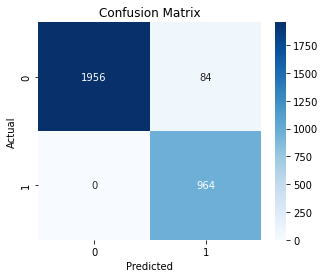

In [7]:
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_prob > 0.4).astype(int)

accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Rainfall Prediction Accuracy: {accuracy:.2f}")
print('Classification Report:\n', classification_report(y_test, y_pred))

# plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

 Prediction

In [8]:
pred_hours = 5 * 24
input_seq = X_temp[-1].reshape(1, X_temp.shape[1], 1)
predicted_temps = []

for _ in range(pred_hours):
    pred = temp_model.predict(input_seq, verbose=0)[0][0]
    predicted_temps.append(pred)
    input_seq = np.roll(input_seq, -1, axis=1)
    input_seq[0, -1, 0] = pred

predicted_temps = scalers['temperature'].inverse_transform(np.array(predicted_temps).reshape(-1, 1))

# generate random future weather data(needs to be changed)
future_cloud_cover = np.random.uniform(df['cloud_cover'].min(), df['cloud_cover'].max(), size=pred_hours)
future_pressure = np.random.uniform(df['pressure'].min(), df['pressure'].max(), size=pred_hours)
future_wind_speed = np.random.uniform(df['wind_speed'].min(), df['wind_speed'].max(), size=pred_hours)
future_humidity = np.random.uniform(df['humidity'].min(), df['humidity'].max(), size=pred_hours)
future_rain_3h = np.random.uniform(df['rainfall_3h'].min(), df['rainfall_3h'].max(), size=pred_hours)

# scale future weather data
future_features = np.column_stack((predicted_temps.flatten(), future_cloud_cover, future_wind_speed, future_humidity, future_pressure, future_rain_3h))

# predict future rainfall
future_rain_prob = xgb_model.predict_proba(future_features)[:, 1]

# generate future rainfall data
dates_future = pd.date_range(df.index[-1], periods=pred_hours + 1, freq='H')[1:]
days = dates_future.normalize().unique()

Visualization